In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import roc_auc_score
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

from lightgbm import *
from shaphypetune import BoostSearch, BoostBoruta, BoostRFE

import warnings
warnings.simplefilter('ignore')

In [2]:
def binary_performances(y_true, y_prob, thresh=0.5, labels=['Positives','Negatives']):
    
    import seaborn as sns
    import matplotlib.pyplot as plt
    from sklearn.metrics import confusion_matrix, auc, roc_curve
    
    shape = y_prob.shape
    if len(shape) > 1:
        if shape[1] > 2:
            raise ValueError('A binary class problem is required')
        else:
            y_prob = y_prob[:,1]
    
    plt.figure(figsize=[15,4])
    
    #1 -- Confusion matrix
    cm = confusion_matrix(y_true, (y_prob>thresh).astype(int))
    
    plt.subplot(131)
    ax = sns.heatmap(cm, annot=True, cmap='Blues', cbar=False, 
                     annot_kws={"size": 14}, fmt='g')
    cmlabels = ['True Negatives', 'False Positives',
               'False Negatives', 'True Positives']
    for i,t in enumerate(ax.texts):
        t.set_text(t.get_text() + "\n" + cmlabels[i])
    plt.title('Confusion Matrix', size=15)
    plt.xlabel('Predicted Values', size=13)
    plt.ylabel('True Values', size=13)
      
    #2 -- Distributions of Predicted Probabilities of both classes
    plt.subplot(132)
    plt.hist(y_prob[y_true==1], density=True, bins=25,
             alpha=.5, color='green',  label=labels[0])
    plt.hist(y_prob[y_true==0], density=True, bins=25,
             alpha=.5, color='red', label=labels[1])
    plt.axvline(thresh, color='blue', linestyle='--', label='Boundary')
    plt.xlim([0,1])
    plt.title('Distributions of Predictions', size=15)
    plt.xlabel('Positive Probability (predicted)', size=13)
    plt.ylabel('Samples (normalized scale)', size=13)
    plt.legend(loc="upper right")
    
    #3 -- ROC curve with annotated decision point
    fp_rates, tp_rates, _ = roc_curve(y_true, y_prob)
    roc_auc = auc(fp_rates, tp_rates)
    plt.subplot(133)
    plt.plot(fp_rates, tp_rates, color='orange',
             lw=1, label='ROC curve (area = %0.3f)' % roc_auc)
    plt.plot([0, 1], [0, 1], lw=1, linestyle='--', color='grey')
    tn, fp, fn, tp = [i for i in cm.ravel()]
    plt.plot(fp/(fp+tn), tp/(tp+fn), 'bo', markersize=8, label='Decision Point')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', size=13)
    plt.ylabel('True Positive Rate', size=13)
    plt.title('ROC Curve', size=15)
    plt.legend(loc="lower right")
    plt.subplots_adjust(wspace=.3)
    plt.show()

    tn, fp, fn, tp = [i for i in cm.ravel()]
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    F1 = 2*(precision * recall) / (precision + recall)
    results = {
        "Precision": precision, "Recall": recall,
        "F1 Score": F1, "AUC": roc_auc
    }
    
    prints = [f"{kpi}: {round(score, 3)}" for kpi,score in results.items()]
    prints = ' | '.join(prints)
    print(prints)
    
    return results

In [3]:
### CREATE SYNTHETIC DATA ### 

X, y = make_classification(n_samples=150_000, 
                           n_features=50, n_informative=11, n_redundant=10,
                           n_classes=2, weights=[0.9, 0.1], class_sep=0.5, 
                           random_state=33, shuffle=True)

X = pd.DataFrame(X, columns=[f"feat_{c}" for c in range(X.shape[1])])
X.shape, y.shape

((150000, 50), (150000,))

In [4]:
### CREATE CATEGORICAL COLUMNS ###

cat_col = [f"feat_{c}" for c in range(10)]
X[cat_col] = X[cat_col].round(2).astype("category")

In [5]:
### TRAIN TEST SPLIT ###

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, shuffle=True, random_state=33)

X_train, X_valid, y_train, y_valid = train_test_split(
    X_train, y_train, test_size=0.2, shuffle=True, random_state=33)

In [6]:
### DEFINE TUNING VARIABLES ###

param_grid = {
    'n_estimators': 200,
    'learning_rate': [0.3, 0.2, 0.1],
    'num_leaves': [20, 25, 30, 35]
}

def AUC(y_true, y_hat):
    return 'auc', roc_auc_score(y_true, y_hat), True

results = {}

lgbm = LGBMClassifier(random_state=0, n_jobs=-1)

In [7]:
### HYPERPARAM TUNING WITH GRID-SEARCH ###

model = BoostSearch(lgbm, param_grid=param_grid, greater_is_better=True)
model.fit(X_train, y_train, eval_set=[(X_valid, y_valid)], eval_metric=AUC, early_stopping_rounds=3, verbose=0)


12 trials detected for ('n_estimators', 'learning_rate', 'num_leaves')

trial: 0001 ### iterations: 00010 ### eval_score: 0.87987
trial: 0002 ### iterations: 00008 ### eval_score: 0.88682
trial: 0003 ### iterations: 00010 ### eval_score: 0.884
trial: 0004 ### iterations: 00007 ### eval_score: 0.87937
trial: 0005 ### iterations: 00025 ### eval_score: 0.90459
trial: 0006 ### iterations: 00016 ### eval_score: 0.8999
trial: 0007 ### iterations: 00018 ### eval_score: 0.89381
trial: 0008 ### iterations: 00021 ### eval_score: 0.90012
trial: 0009 ### iterations: 00009 ### eval_score: 0.89066
trial: 0010 ### iterations: 00014 ### eval_score: 0.89568
trial: 0011 ### iterations: 00013 ### eval_score: 0.88415
trial: 0012 ### iterations: 00010 ### eval_score: 0.88876


<shaphypetune.BoostSearch>

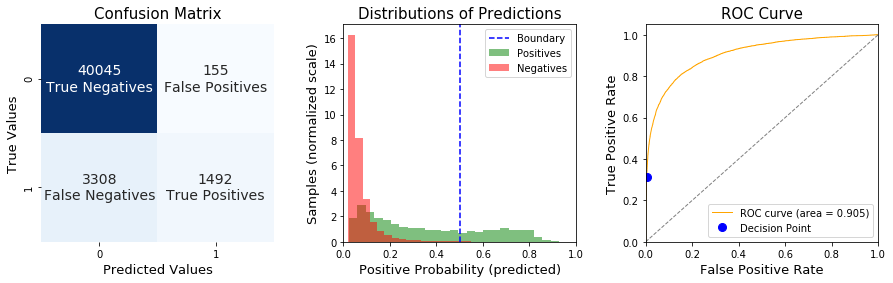

Precision: 0.906 | Recall: 0.311 | F1 Score: 0.463 | AUC: 0.905


In [8]:
### PLOT AND STORE RESULTS ###

results['Param Tuning'] = binary_performances(y_test, model.predict(X_test, method='predict_proba'))

In [9]:
### HYPERPARAM TUNING WITH GRID-SEARCH + RECURSIVE FEATURE ELIMINATION (RFE) ###

model = BoostRFE(lgbm, param_grid=param_grid, min_features_to_select=10, step=3, greater_is_better=True)
model.fit(X_train, y_train, eval_set=[(X_valid, y_valid)], eval_metric=AUC, early_stopping_rounds=3, verbose=0)


12 trials detected for ('n_estimators', 'learning_rate', 'num_leaves')

trial: 0001 ### iterations: 00010 ### eval_score: 0.87987
trial: 0002 ### iterations: 00008 ### eval_score: 0.88682
trial: 0003 ### iterations: 00014 ### eval_score: 0.88941
trial: 0004 ### iterations: 00012 ### eval_score: 0.88275
trial: 0005 ### iterations: 00025 ### eval_score: 0.90459
trial: 0006 ### iterations: 00022 ### eval_score: 0.90515
trial: 0007 ### iterations: 00027 ### eval_score: 0.90146
trial: 0008 ### iterations: 00025 ### eval_score: 0.90454
trial: 0009 ### iterations: 00020 ### eval_score: 0.89959
trial: 0010 ### iterations: 00014 ### eval_score: 0.89568
trial: 0011 ### iterations: 00020 ### eval_score: 0.89687
trial: 0012 ### iterations: 00015 ### eval_score: 0.89909


<shaphypetune.BoostRFE>

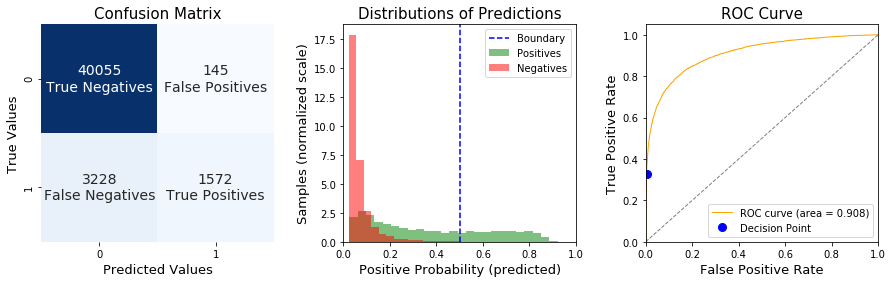

Precision: 0.916 | Recall: 0.328 | F1 Score: 0.482 | AUC: 0.908


In [10]:
### PLOT AND STORE RESULTS ###

results['Param Tuning + RFE'] = binary_performances(y_test, model.predict(X_test, method='predict_proba'))

In [11]:
### HYPERPARAM TUNING WITH GRID-SEARCH + RECURSIVE FEATURE ELIMINATION (RFE) WITH SHAP ###

model = BoostRFE(lgbm, param_grid=param_grid, min_features_to_select=10, step=3, greater_is_better=True,
                 importance_type='shap_importances', train_importance=False)
model.fit(X_train, y_train, eval_set=[(X_valid, y_valid)], eval_metric=AUC, early_stopping_rounds=3, verbose=0)


12 trials detected for ('n_estimators', 'learning_rate', 'num_leaves')

trial: 0001 ### iterations: 00046 ### eval_score: 0.91769
trial: 0002 ### iterations: 00026 ### eval_score: 0.91573
trial: 0003 ### iterations: 00061 ### eval_score: 0.93528
trial: 0004 ### iterations: 00035 ### eval_score: 0.91223
trial: 0005 ### iterations: 00062 ### eval_score: 0.91467
trial: 0006 ### iterations: 00030 ### eval_score: 0.90345
trial: 0007 ### iterations: 00085 ### eval_score: 0.91516
trial: 0008 ### iterations: 00024 ### eval_score: 0.90362
trial: 0009 ### iterations: 00064 ### eval_score: 0.91703
trial: 0010 ### iterations: 00071 ### eval_score: 0.94459
trial: 0011 ### iterations: 00051 ### eval_score: 0.90968
trial: 0012 ### iterations: 00010 ### eval_score: 0.89363


<shaphypetune.BoostRFE>

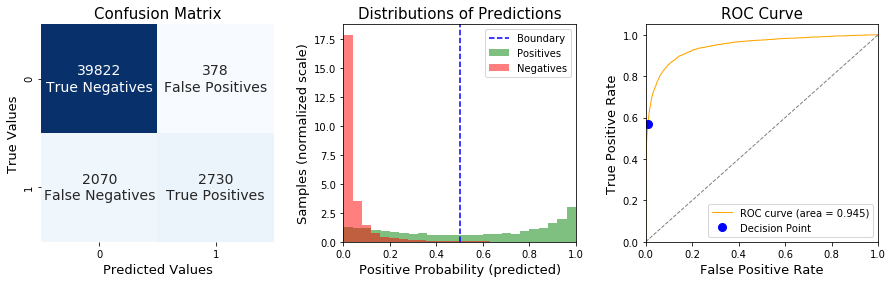

Precision: 0.878 | Recall: 0.569 | F1 Score: 0.69 | AUC: 0.945


In [12]:
### PLOT AND STORE RESULTS ###

results['Param Tuning + RFE w/ SHAP'] = binary_performances(y_test, model.predict(X_test, method='predict_proba'))

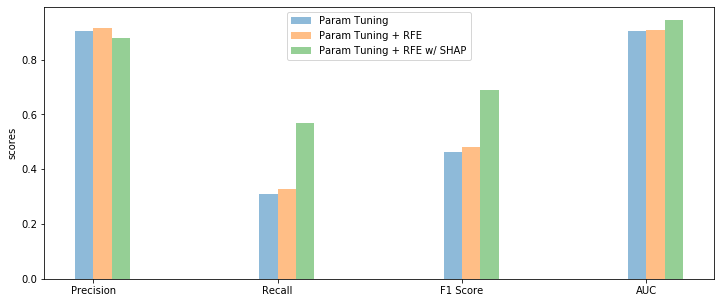

In [13]:
### PLOT AND COMPARE RESULTS ###

plt.figure(figsize=(12,5))

plt.bar(np.arange(4)-0.05, results['Param Tuning'].values(), 
        alpha=0.5, width=0.1, label='Param Tuning')
plt.bar(np.arange(4)+0.05, results['Param Tuning + RFE'].values(), 
        alpha=0.5, width=0.1, label='Param Tuning + RFE')
plt.bar(np.arange(4)+0.15, results['Param Tuning + RFE w/ SHAP'].values(), 
        alpha=0.5, width=0.1, label='Param Tuning + RFE w/ SHAP')

plt.xticks(range(4), results['Param Tuning'].keys())
plt.ylabel('scores'); plt.legend()
plt.show()